In [20]:
import numpy as np, matplotlib.pyplot as plt, os, sys, csv
from shapely.geometry import Point, Polygon
import pandas as pd, pickle

from sklearn.neural_network import MLPClassifier
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split

# use geojson to import political border info
import gmaps.geojson_geometries
import requests
import numpy.random as random

# need to enable Maps JavaScript API, Directions, Elevation, Geocoding 
APIkey = open('../API_KEY.txt', 'r').readlines()[0]
countries_geojson = gmaps.geojson_geometries.load_geometry('countries')
gmaps.configure(api_key=APIkey)
%matplotlib inline

### Read in city data from cvs file

In [199]:
us_path = './csvs/uscities.csv'
print_cols = ['city', 'state_name', 'population', 'lat', 'lng']

usdf = pd.read_csv(us_path , sep=',')
usdf = usdf[[x not in ['Puerto Rico', 'District of Columbia', 'Hawaii', 'Alaska'] 
             for x in usdf['state_name']]]

print(usdf[print_cols][:5])

          city  state_name  population      lat       lng
0     New York    New York    18713220  40.6943  -73.9249
1  Los Angeles  California    12750807  34.1139 -118.4068
2      Chicago    Illinois     8604203  41.8373  -87.6862
3        Miami     Florida     6445545  25.7839  -80.2102
4       Dallas       Texas     5743938  32.7936  -96.7662


### Plot all cities with circle size proportional to population

Text(0, 0.5, 'Latitude')

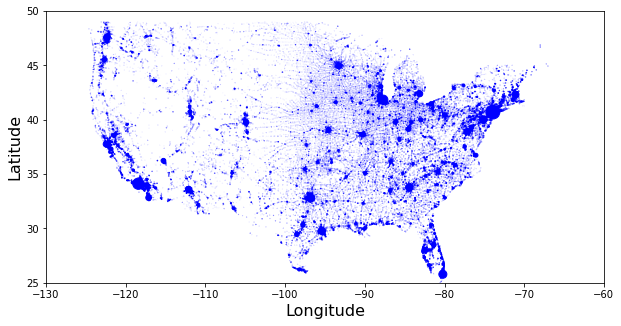

In [37]:
fig, axes = plt.subplots(figsize=(10, 5))
pop_norm = 0.00001

axes.scatter(usdf['lng'], usdf['lat'], s=usdf['population']*pop_norm, color='blue')

axes.set_xlim(-130, -60)
axes.set_ylim(25, 50)
axes.set_xlabel('Longitude', fontsize=16)
axes.set_ylabel('Latitude', fontsize=16)

### Build a grid of points contained within continental US

In [181]:
def build_grid(latstep=0.2, lngstep=0.1):
    '''return a grid of points all within USA boundaries'''

    latmin, latmax = -130, -60
    lngmin, lngmax = 25, 50

    # find usa polygon list from given indices
    usa_idx, alaska_idx, mainland_idx = 205, 84, 22
    usa_poly_list = countries_geojson['features'][usa_idx]['geometry']['coordinates']
    mainland_border = [(coord[1], coord[0]) for coord in usa_poly_list[mainland_idx][0]]
    mainland_polygon = gmaps.Polygon(mainland_border,stroke_color='black')
    poly = Polygon(mainland_polygon.path)

    grid_list = []
    for lat in np.arange(latmin, latmax, latstep):
        for lng in np.arange(lngmin, lngmax, lngstep):
            pt = Point(lng, lat)
            if poly.contains(pt):
                grid_list.append([lat, lng])
                
    return np.array(grid_list)

grid = build_grid()

### Unsupervised clustering using kmeans

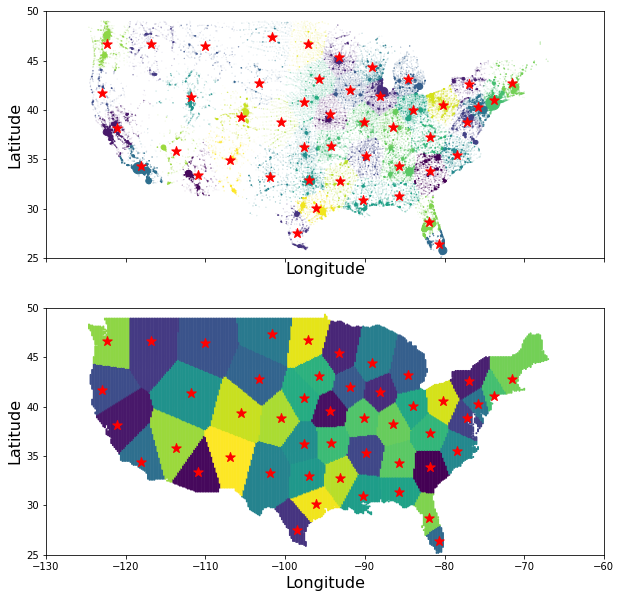

In [198]:
fig, axes = plt.subplots(2, figsize=(10, 10), sharey=True, sharex=True)
pnorm = 1
                         
X = usdf[['lng', 'lat']]
kmeans = KMeans(n_clusters=48, random_state=0).fit(X)
                         
city_clusters = kmeans.predict(X)
grid_clusters = kmeans.predict(grid)
       
axes[0].scatter(usdf['lng'], usdf['lat'], s=pop_norm*usdf['population'], c=city_clusters)
axes[0].scatter(*kmeans.cluster_centers_.T, marker="*",s=100,c='red')
    
axes[1].scatter(grid[:, 0], grid[:, 1], s=pnorm*np.ones(len(grid)), c=grid_clusters)
axes[1].scatter(*kmeans.cluster_centers_.T, marker="*",s=100,c='red')

for ax in axes:
    ax.set_xlim(-130, -60)
    ax.set_ylim(25, 50)
    ax.set_xlabel('Longitude', fontsize=16)
    ax.set_ylabel('Latitude', fontsize=16)

### Use surpervised learning to classify cities into states

In [193]:
X, y = usdf[['lng', 'lat']], usdf['state_name']
state_list = list(set(usdf['state_name']))
pred_list, grid_list, score_list = [], [], []

split_list = [0.9, 0.5, 0.1]
epochs_list = [10, 50, 500]
pair_list = []

for split in split_list:
    for epochs in epochs_list:

        # split data into test and train sets
        X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y,random_state=1, test_size=split)

        # train classifier
        clf = MLPClassifier(random_state=1, max_iter=epochs, hidden_layer_sizes=(100)).fit(X_train, y_train)
        print(f'Done training {split} {epochs}')

        # predict values using classifier
        all_pred = clf.predict(X)
        grid_pred = clf.predict(grid)
        score = clf.score(X_test, y_test)
        
        # append values to list
        pred_list.append(all_pred)
        score_list.append(score)
        grid_list.append(grid_pred)
        pair_list.append((split, epochs))
        

/home/mrjoness/anaconda3/envs/gmaps_env/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(


Done training 0.9 10


/home/mrjoness/anaconda3/envs/gmaps_env/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(


Done training 0.9 50


/home/mrjoness/anaconda3/envs/gmaps_env/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


Done training 0.9 500


/home/mrjoness/anaconda3/envs/gmaps_env/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(


Done training 0.5 10


/home/mrjoness/anaconda3/envs/gmaps_env/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(


Done training 0.5 50


/home/mrjoness/anaconda3/envs/gmaps_env/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


Done training 0.5 500


/home/mrjoness/anaconda3/envs/gmaps_env/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(


Done training 0.1 10


/home/mrjoness/anaconda3/envs/gmaps_env/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(


Done training 0.1 50


/home/mrjoness/anaconda3/envs/gmaps_env/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


Done training 0.1 500


### Plot results for various training parameters

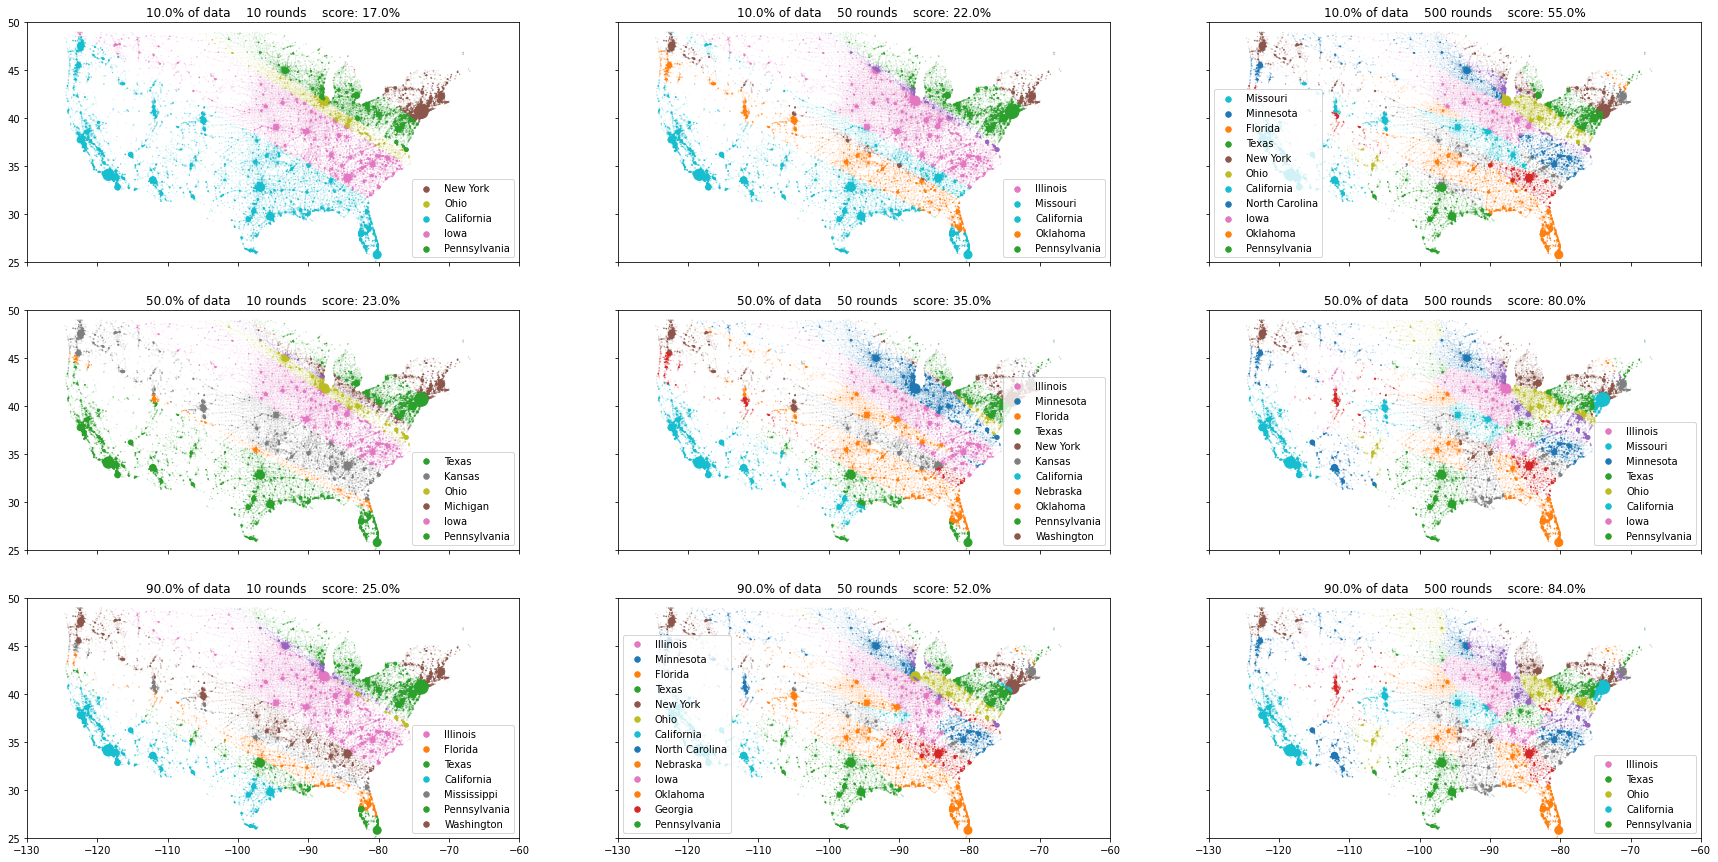

In [194]:
fig, axes = plt.subplots(3, 3, figsize=(30, 15), sharey=True, sharex=True)
pop_norm = 0.00001

for (split, epochs), y_pred, grid_pred, score, ax in zip(pair_list, pred_list, grid_list, score_list, axes.flatten()):

    for state in state_list:
        #ix = np.where(np.array(usdf['state_name']) == state)[0]
        #axes[0].scatter(np.array(usdf['lng'])[ix], np.array(usdf['lat'])[ix], 
                     #s=np.array(usdf['population'])[ix]*pop_norm, label=state)

        ix = np.where(y_pred == state)[0]
        if len(ix)> 1000: label= state
        else: label = ''
        ax.set_title(f'{np.round((1-split)*100)}% of data    {epochs} rounds    score: {np.round(score*100)}%')
        ax.scatter(np.array(usdf['lng'])[ix], np.array(usdf['lat'])[ix], 
                     s=np.array(usdf['population'])[ix]*pop_norm, label=label)

    ax.set_xlim(-130, -60)
    ax.set_ylim(25, 50)
    leg = ax.legend()
    for lp in leg.legendHandles: lp._sizes = [30]
    
#axes[0, 1].set_xlabel('Longitude', fontsize=20)
#axes[1, -1].set_ylabel('Latitude', fontsize=20)

### Use grid points to evenly sample the US

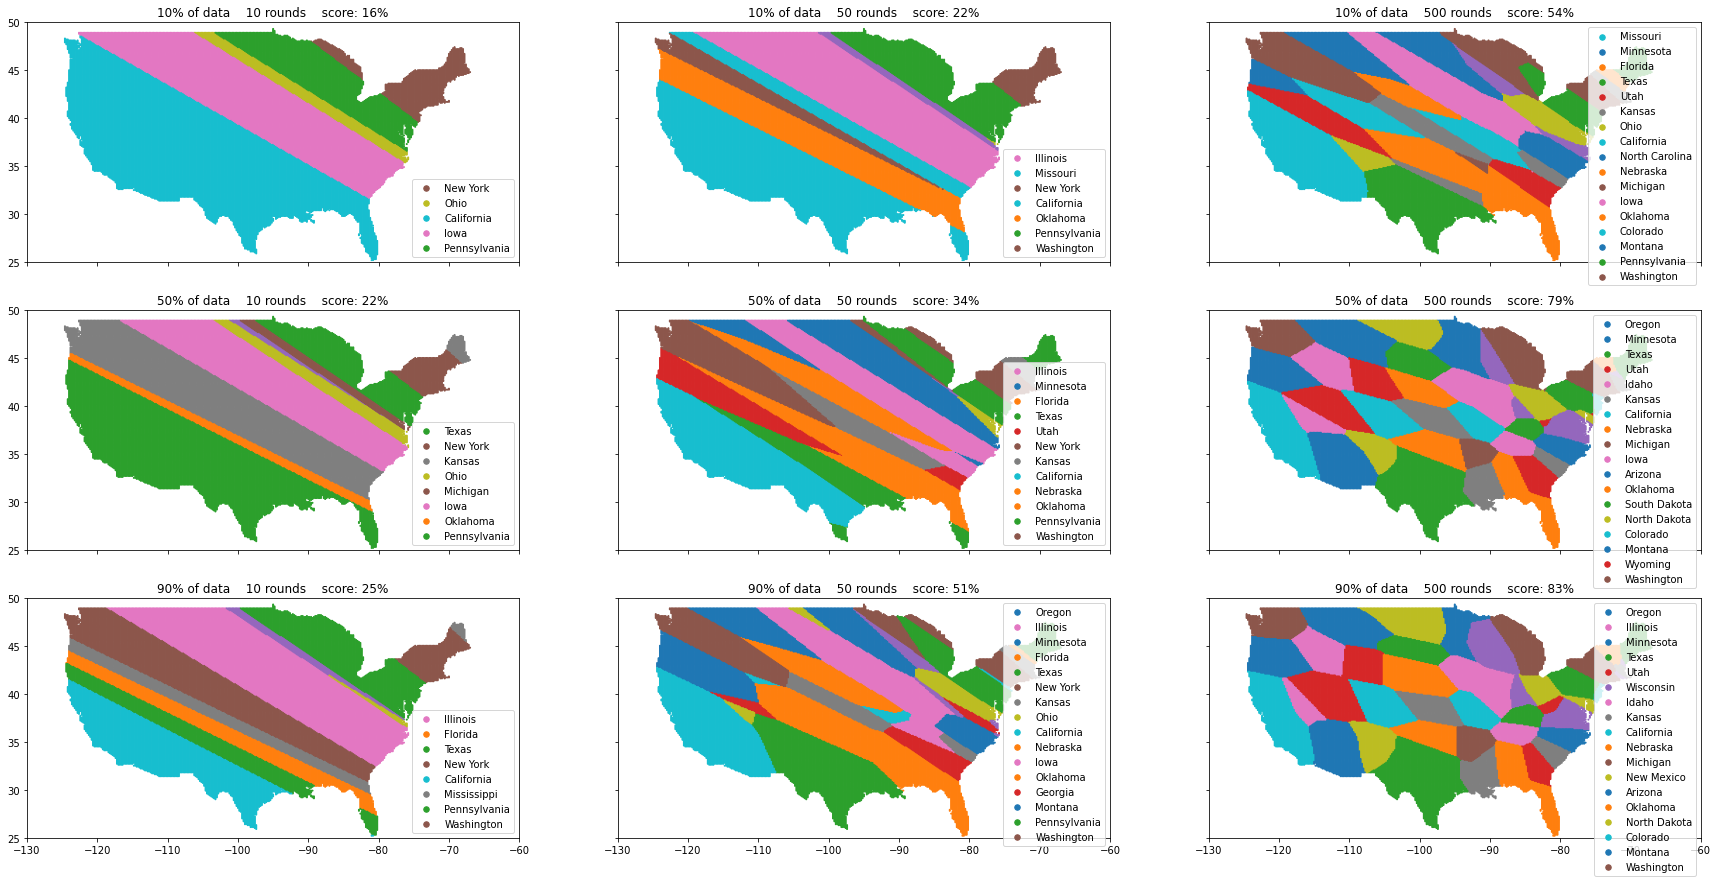

In [195]:
fig, axes = plt.subplots(3, 3, figsize=(30, 15), sharey=True, sharex=True)
pnorm = 1

for (split, epochs), y_pred, grid_pred, score, ax in zip(pair_list, pred_list, grid_list, score_list, axes.flatten()):

    for state in state_list:
        #ix = np.where(np.array(usdf['state_name']) == state)[0]
        #axes[0].scatter(np.array(usdf['lng'])[ix], np.array(usdf['lat'])[ix], 
                     #s=np.array(usdf['population'])[ix]*pop_norm, label=state)

        ix = np.where(grid_pred == state)[0]
        if len(ix)> 1000: label= state
        else: label = ''
        ax.set_title(f'{int(round((1-split)*100))}% of data    {epochs} rounds    score: {int(score*100)}%')
        ax.scatter(grid[:, 0][ix], grid[:, 1][ix], s=pnorm*np.ones(len(ix)), label=label)

    ax.set_xlim(-130, -60)
    ax.set_ylim(25, 50)
    leg = ax.legend()
    for lp in leg.legendHandles: lp._sizes = [30]
    
#axes[0, 1].set_xlabel('Longitude', fontsize=20)
#axes[1, -1].set_ylabel('Latitude', fontsize=20)